#### How to build ML Pipelines using DVC?

- We have a data of tweeter
- We have to find sentiment of the tweet
- we need to build emotion detection tool

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split 
import re 
import string
import nltk 
import string 
from nltk. corpus import stopwords 
from nltk.stem import SnowballStemmer, WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer 
import xgboost as xgb 
from sklearn.metrics import accuracy_score, classification_report 
from sklearn.metrics import precision_score, recall_score, roc_auc_score 

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/campusx-official/jupyter-masterclass/main/tweet_emotions.csv')
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [3]:
df.drop(columns=['tweet_id'], inplace=True)

In [4]:
df.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


#### basic data pre processing

In [5]:
final_df = df[df['sentiment'].isin(['happiness','sadness'])]

In [6]:
final_df.shape

(10374, 2)

In [7]:
final_df['sentiment'] = final_df['sentiment'].replace(
    {
        'happiness': 1,
        'sadness': 0
    }
)

C:\Users\iampr\AppData\Local\Temp\ipykernel_22272\1062716855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['sentiment'] = final_df['sentiment'].replace(


In [8]:
final_df.sample(5)

,sentiment,content
32376,1,@JonathanRKnight you &amp; chicken soup &amp; ...
4978,0,michael scofiled Noooooo !! I hate the writer...
14304,0,It's Hollie spelt with an 'ie' not a y!! She m...
10076,0,oh how I miss my truck... I could have my whol...
26408,0,@LesNoyse when will she b finished


In [9]:
train_data, test_data = train_test_split(final_df, test_size=0.2, random_state=42)

In [10]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\iampr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\iampr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    text = text.split()
    text = [lemmatizer.lemmatize(y) for y in text]
    return " ".join(text)

def remove_stop_words (text):
    stop_words = set(stopwords.words('english'))
    Text = [i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def removing_numbers(text):
    text = "".join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):
    text = text.split()
    text = [y.lower() for y in text]
    return " ".join(text)


def removing_punctuations(text):
    # Remove punctuation using regex and string.punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    
    #remove extra whitespace
    text = re.sub('\s+',' ', text)
    text = " ".join(text.split())
    return text.strip()


def removing_urls(text):
    url_pattern = re.compile(r'https://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[1] = np.nan
            
            
def normalize_text(df):
    df.content = df.content.apply(lambda content : lower_case(content))
    df.content = df.content.apply(lambda content : remove_stop_words(content))
    df.content = df.content.apply(lambda content : removing_numbers(content))
    df.content = df.content.apply(lambda content : removing_punctuations(content))
    df.content = df.content.apply(lambda content : removing_urls(content))
    df.content = df.content.apply(lambda content : lemmatization(content))    
    return df


def normalize_sentence(sentence):
    sentence = lower_case(sentence)
    sentence = remove_stop_words(sentence)
    sentence = removing_numbers(sentence)
    sentence = removing_punctuations(sentence)
    sentence = removing_urls(sentence)
    sentence = lemmatization(sentence)
    return sentence

In [12]:
normalize_sentence("Thats it? It's done already? This is one")

'thats it done already one'

In [13]:
train_data = normalize_text(train_data)
test_data = normalize_text(test_data)

In [14]:
#extract x-train, x-test, y-train, y-test
X_train = train_data['content'].values
y_train = train_data['sentiment'].values

X_test = test_data['content'].values
y_test = test_data['sentiment'].values

#### advanced data pre processing - Text vectorization

In [15]:
#bow vectorizer
vectorizer = CountVectorizer()
x_train_bow = vectorizer.fit_transform(X_train)
x_test_bow = vectorizer.transform(X_test)

In [16]:
train_df = pd.DataFrame(x_train_bow.toarray())
train_df['label'] = y_train
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,14223,14224,14225,14226,14227,14228,14229,14230,14231,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### data modelling -- XGBoost

In [17]:
# Train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(x_train_bow, y_train)

# Predict on test data
y_pred = xgb_model.predict(x_test_bow)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_rep)

c:\Users\iampr\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:158: UserWarning: [20:49:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7716
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.83      0.79      1060
           1       0.80      0.71      0.75      1015

    accuracy                           0.77      2075
   macro avg       0.77      0.77      0.77      2075
weighted avg       0.77      0.77      0.77      2075



#### evaluation

In [ ]:
y_pred = xgb_model.predict(x_test_bow)
y_pred_proba = xgb_model.predict_proba(x_test_bow)[:,1]

#evaluation metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

In [19]:
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"auc: {auc}")

precision: 0.7988950276243094
recall: 0.7123152709359606
auc: 0.8595775629705363


- The current workflow is a simplified version and does not include essential steps such as experimenting with different vectorization techniques, machine learning algorithms, or hyperparameter tuning.

- Building the entire project in a single file is not recommended, as it limits scalability and maintainability. A modular approach offers several advantages:

    - Easier collaboration
    - Simplified debugging and maintenance

- To improve structure and efficiency, we should adopt a modular pipeline by creating separate scripts for each stage:
    
    1. Data Ingestion
    2. Data Transformation
    3. Feature Engineering
    4. Model Training
    5. Model Evaluation

- After that we can create a `dvc.yaml` file to connect all stages and run them sequentially using thier output as input

- NEXT, We can improve the code:
    1. modular coding using functions or OOPs
    2. logging -- logging requires an object: `logger` which need 2 objects: `handler`(where to show logging messages console or log file, `formatter` how message will look like)
    3. params.yaml
    4. try exception
    5. type hinting

- Create Virtual ENV: venv, and create requirements.txt file

#### `DVC ML Pipeline & data versioning`

**Why Require**

1. Reproducibility
If your model performs well today, you should be able to reproduce the same result tomorrow. Data versioning ensures the exact same dataset used during training is available later for auditing or debugging.

2. Experiment Tracking
Different versions of your data may produce different model performance. Versioning lets you compare how model accuracy changes as you clean, augment, or rebalance your dataset.

3. Safe Experimentation
You can safely try new preprocessing techniques or labeling strategies. If it breaks something, just roll back to the previous data version.

4. Team Collaboration
Teams working on the same project might otherwise use inconsistent data. Versioning ensures that everyone’s working from the same snapshot of the dataset.

5. Audit & Compliance
In production environments, especially in regulated industries (finance, healthcare), you often need to explain what data was used to train a particular model. Versioned data = full traceability.


**How**
- While we can easily roll back to previous versions of code using `git checkout`, the same is not true for data.
- DVC (Data Version Control) maintains a data repository, either locally or in the cloud, similar to how Git manages code on GitHub.
- DVC generates metadata for data files with unique IDs, which can be pushed alongside the code to Git.
- When performing a `git checkout`, DVC reads the metadata file and updates the data file by fetching the correct version of the data from the local or cloud storage.

**Project Setup**

1. Create project template
2. git init
3. dvc init
4. dvc remote add -d myremote "local folder path" or "cloud storage path like S3 url"
5. In case of pipelines, we dont have add data files for dvc to track them, It will automatically track `out` files
6. `dvc rero` will run the pipeline and automatically track all files
7. All metadata can be found in `dvc.lock`
8. dvc status will show: Data and pipelines are up to date
9. git status will show all the code & file changes
10. git add, commit, dvc push and git push
11. In github repo, all the outs will not be visible since they are saved in dev repo whcih is in our case temp folder
12. If we make any changes in code which will induce changes in data then it will be tracked by DVC -- like changing max_features which will make dvc repro to run all stages again... dvc status will show pipeline up to date but git status will show all changes like max feature file, dvc.lock file since all metadata is inside this file etc -- We can add & commit them, dvc push and git push
13. We have 3 changes

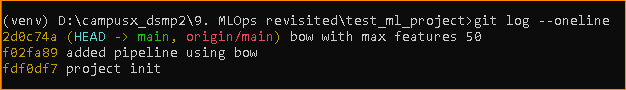

14. In order to roll back code and data:
    - we can do `git checkout f02fa89` which will change code but not data
    - In order to roll back the data also, we can do `dvc checkout`

#### `Experiment Tracking` & `Model registry` using MLFlow and DagsHub


##### Why it is required?

- As data scientists, we often run numerous experiments—trying different preprocessing techniques, feature engineering methods, and machine learning algorithms—to identify what yields the best results on our data.
- However, after performing many such experiments, a key question arises:
- How do we effectively compare them and identify which changes led to improvements?
- This is where `Experiment Tracking` becomes essential.

- It helps us:
    + Log and compare different runs,
    + Monitor performance metrics,
    + Track model configurations and parameters,
    + And ultimately, understand what works best—and why.

- `Experiment tracking` in machine learning development is a process to track and store all data related to each experiment such as hyperparameters, data & code versions, environment, metrics, artifacts etc

- **Benefits** 
1. Reproducibility: It ensures that same experiment can be preproduced later
2. comparison: To compare what works and how it effects the results
3. collabration
4. insights
5. auditability

#### MLFlow

1. Experiment Tracking: Keep track of different machine learning experiments, including parameters, metrics, and artifacts.
2. Model Registry: Store and manage multiple versions of trained models in a central registry for easier deployment and comparison.
3. Model Serving (with DagsHub): Use platforms like DagsHub to serve and share models directly from MLflow with version control and collaborative tools.


**How**
- mlflow ui: to run mlflow tracking server, It could be local or on cloud for better collabration
- UI have 2 tabs: experiments (experiemtn tracking) & models (model registry)
- `experiment vs run`: lets say we hav a ml problem of students, iq and predict placement. I initially tried ranadom forest and results were not good so I tried deep learning ANN.
- trying with random forest will be 1st experiment and with deep learning will be 2nd `experiment`
- trying same experiment with different parameters will be `run`

**example:**
- When planning a project, we start with a baseline model where we run any algorithm which we think will give better result that will be `experiment1`
- next we add feature engineering and ran again that will be `experiment2`
- next we used hyper parameter tuning that will be `experiment3`
- we compare the results and figure out which works the best and which technique will be used in production

**Practical Example**

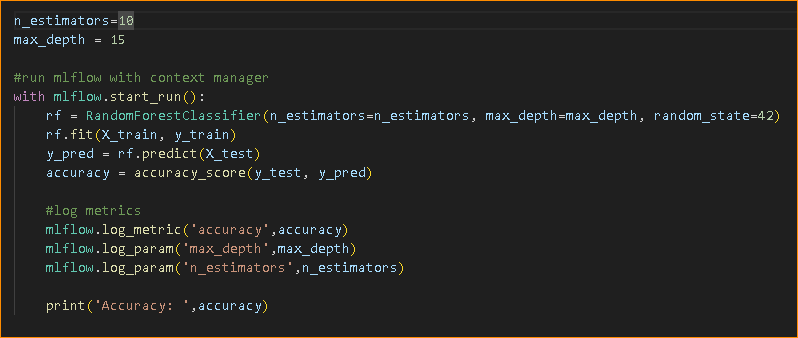

- We ran 2 experiments by changing the value of parameters
- All details are logged in mlflow ui and under mlruns

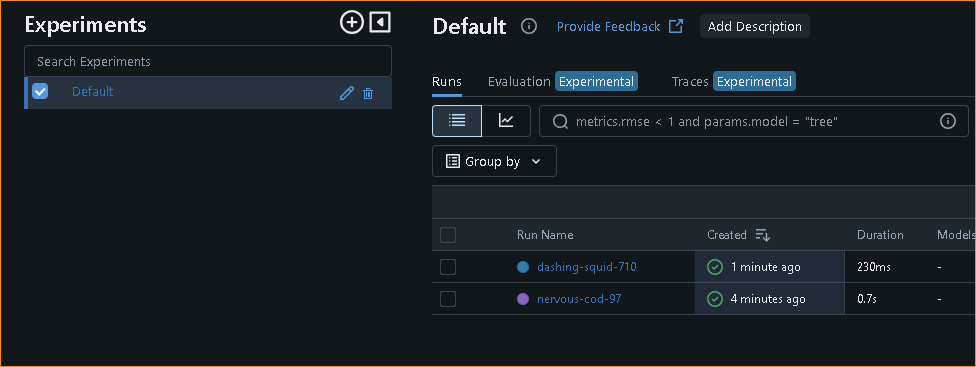

- We can compare the runs by selecting them

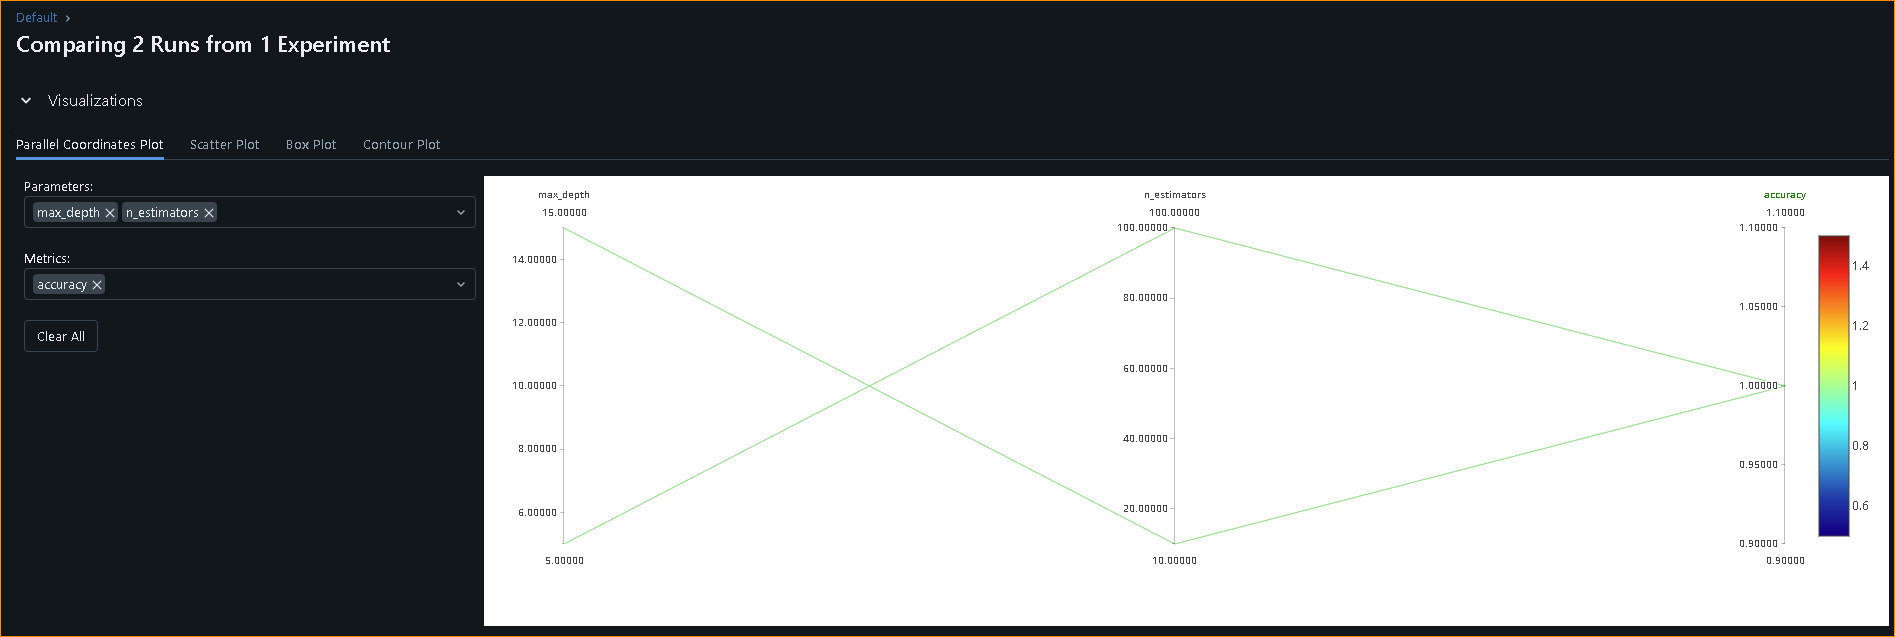

- Uptill now we have used default experiment and 2 runs, Lets now create 2nd experiment using decision tree
- In order to create 2nd experiment, we can add new experiment using UI and either refer it to that experiment name in code OR use experiment id of that experiment in code

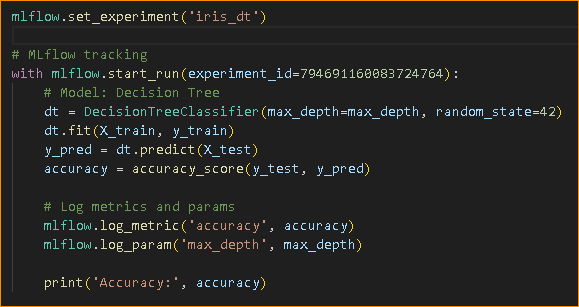

- mlruns folder will also show both experiments

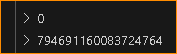

- We can also explicitly give a name to the run 

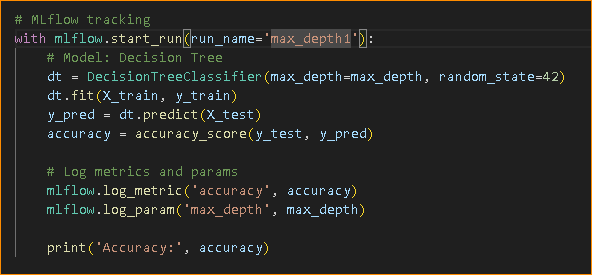

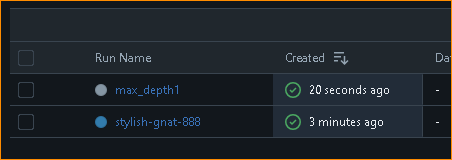


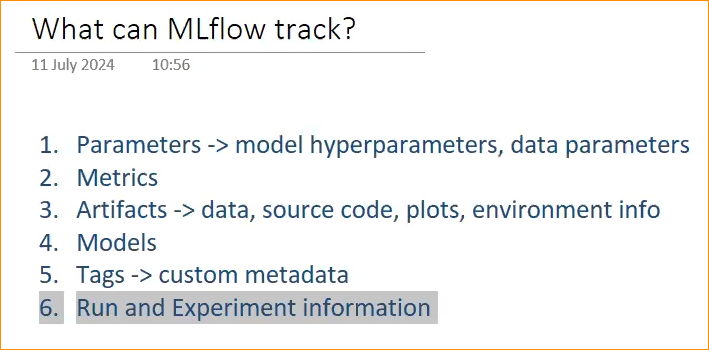

- To log artifact (heatmap)
- `mlflow.log_artifact(heatmap_path)`
- A new folder `mlflowartifacts` folder will also be created

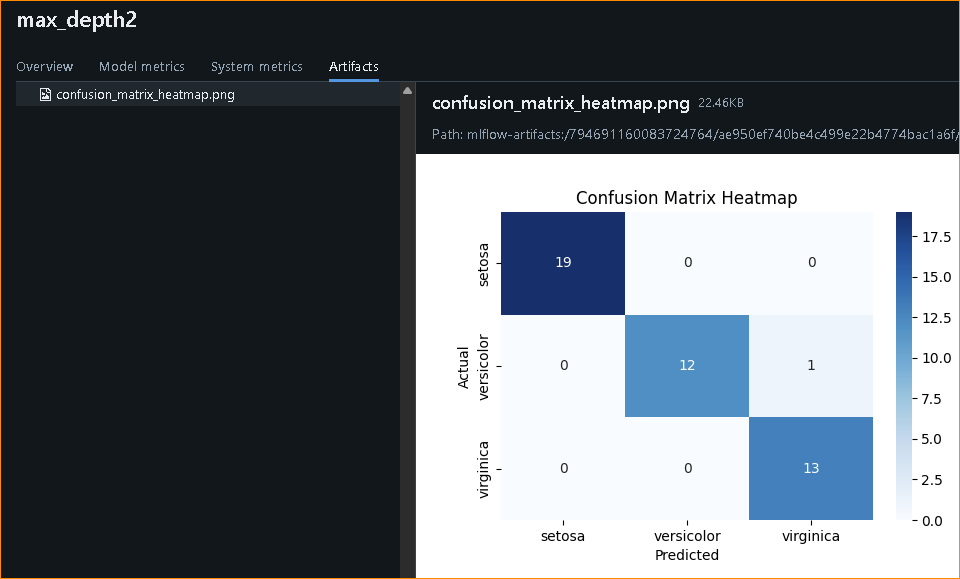


- `log code`
- mlflow.log_artifact(__file__)

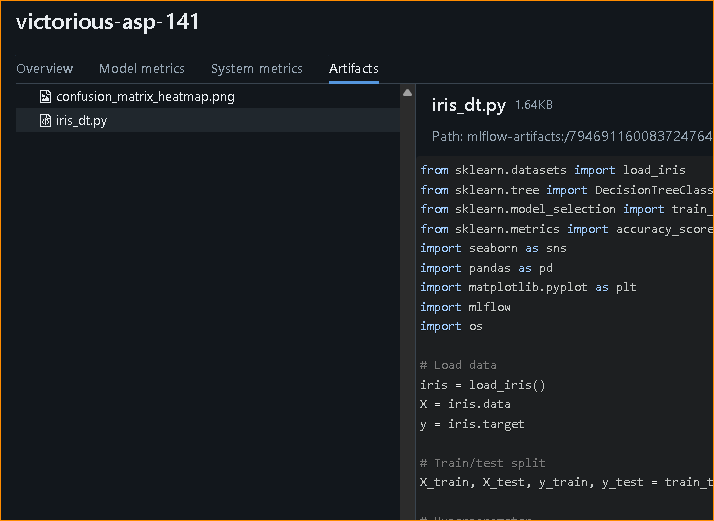

- `log model`
- mlflow.sklearn.log_model(dt,'Decision Tree')

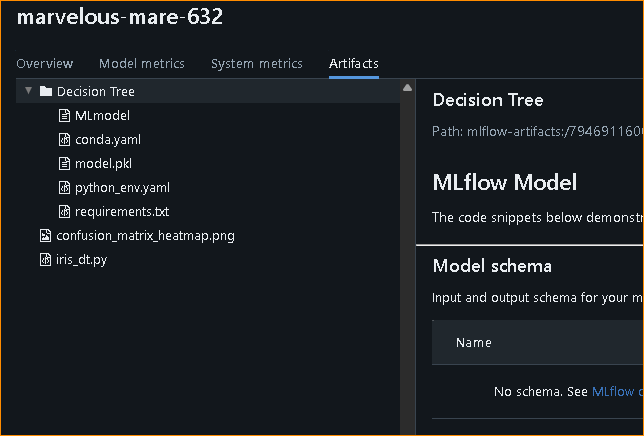


- **set tags**
- mlflow.set_tag('author','PrashantJ')
- mlflow.set_tag('model','DT')
- Tags will help us to search experiments in future when we will have 1000s of experiments or runs

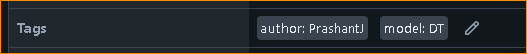

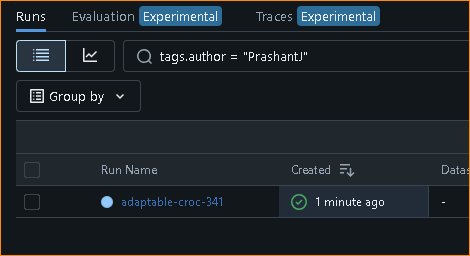

#### MLFlow (remote tracking server)

1. Dagshub (easy)
2. AWS (complex)

- change set tracking server url to dagshub experiment url
- add dagshub experiment code
- now when we run, It will reflect on dagshub mlflow UI
- multiple developer can run the experiment simultaneously, they can clone the git repo and run thier experiment using different algorithm
- all experiments will be visible on dagshub central tracking mlflow ui

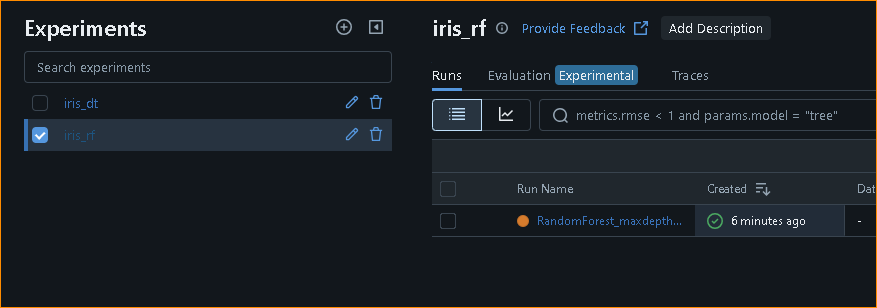

#### Advanced MLFlow

1. Hyper parameter tuning
2. Model registry
3. Auto logging
4. Log input data

##### To log data, we need mlflow dataframe

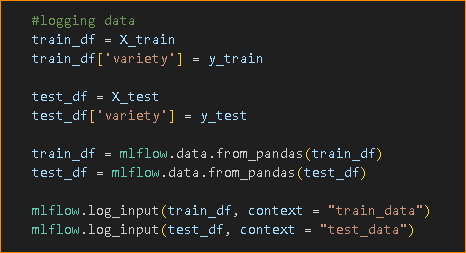

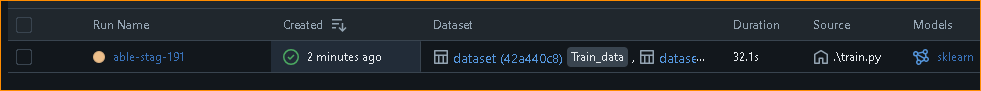

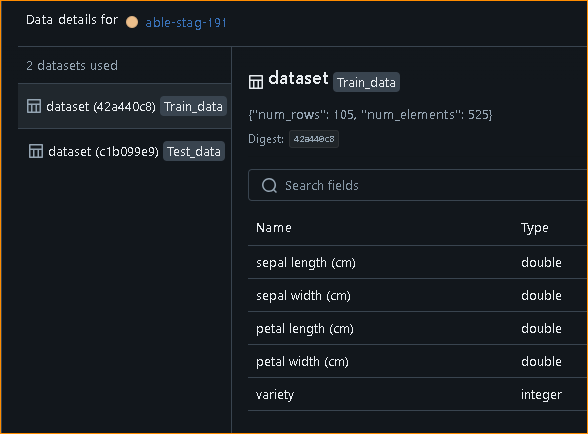

##### Auto logging

- We can log params without explicitly defining what to log
- Generally, In industry we choose what to log bcoz auto logging logs everything which makes it cluttered

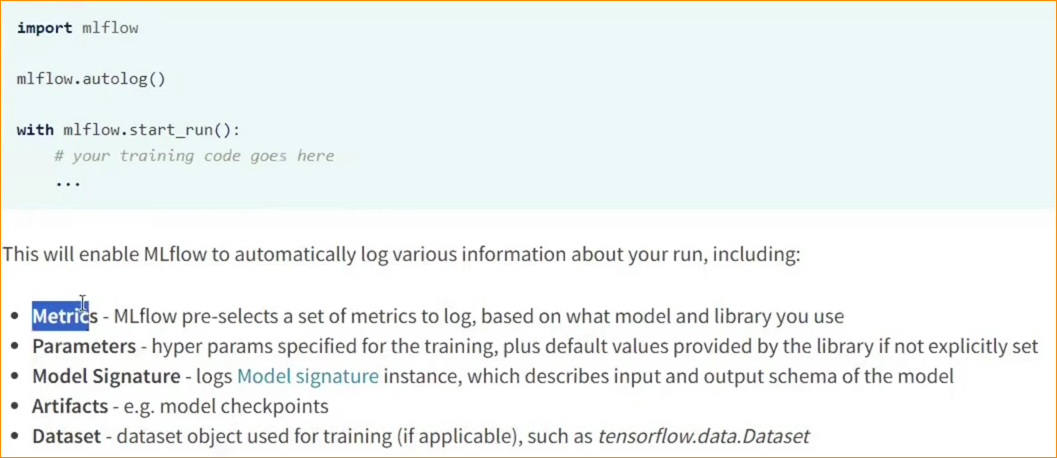

#### Hyper parameter tuning

- We will use pima indian diabetes data
- train using grid search cv and log all experiments with different parameters

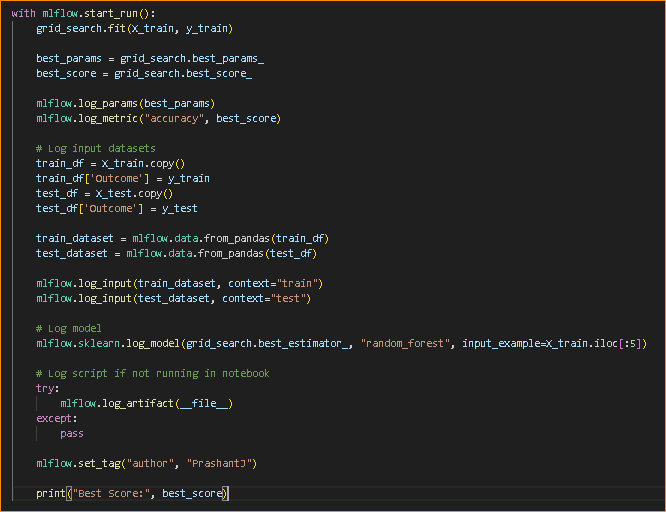

- we log each combination instead of best combination when performing hyper parameter tuning
- we use nested run
- run 2 nested `with statements` : parent contains best run & child contains all other combination runs

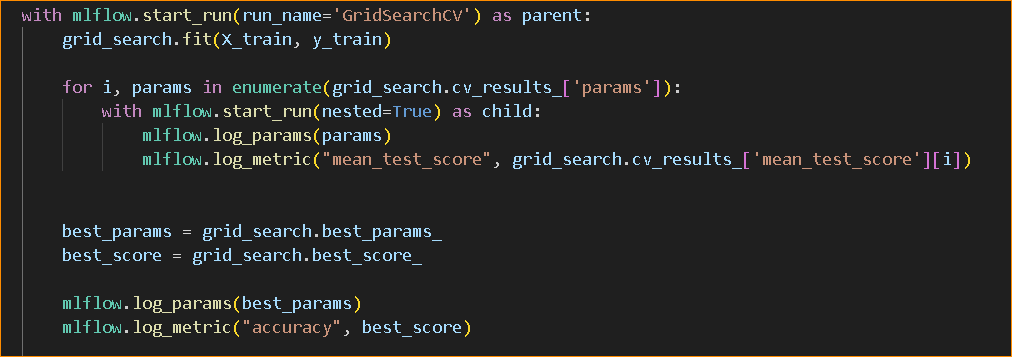

- **Whats the benegit?**
- We can now compare b/w all runs and experiments whats is effecting the accuracy and tweak to achieve best accuracy

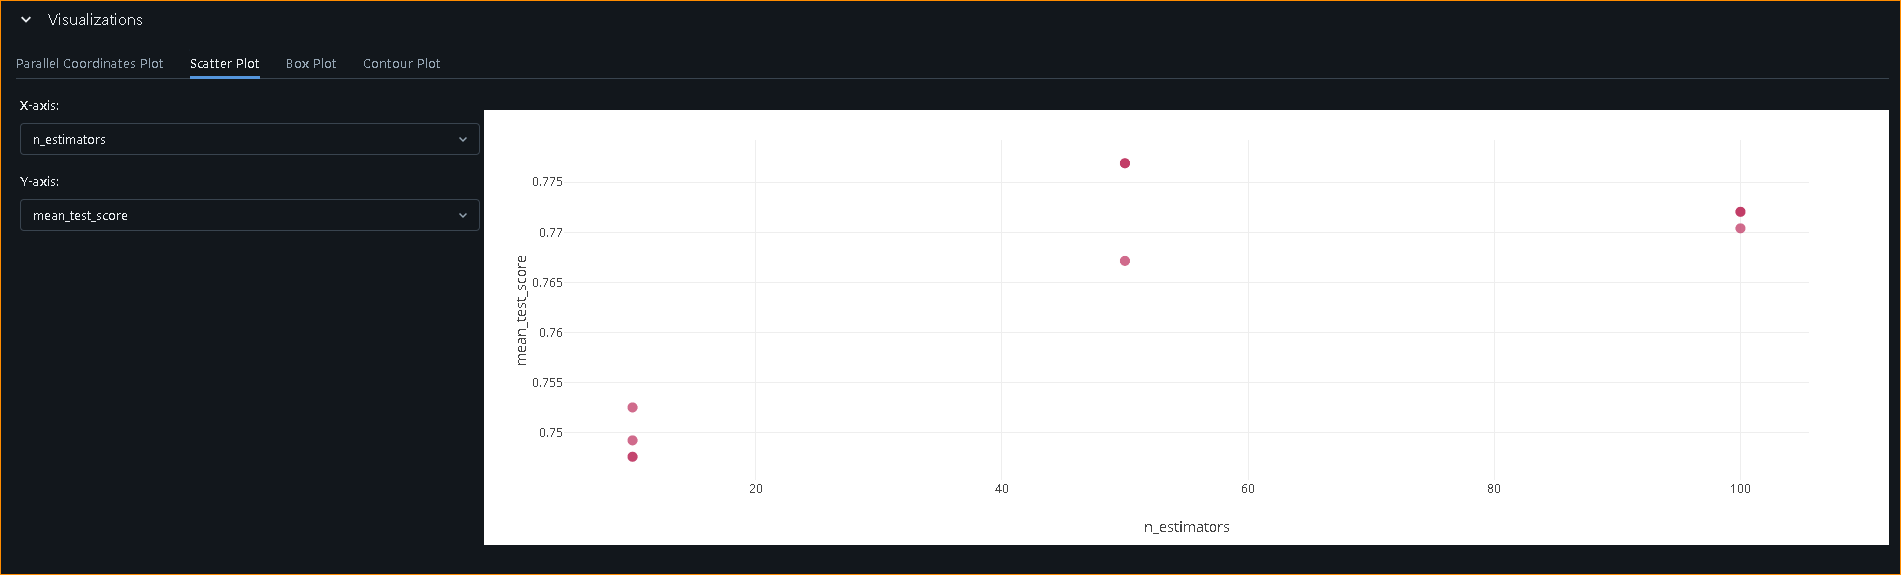

#### Model Registry

- Model Registry is a central hub for managing the lifecycle of machine learning models.
- Similar to how GitHub manages code and DVC handles data, the registry tracks, versions, and organizes models across stages like Staging, Production, and Archived.
- ML developers register models in the Model Registry, and the operations team uses them for deployment to production.
- It is the midpoint of the entire MLOps journey.
- Model logging in experiment tracking is different from the Model Registry.
- The Model Registry stores the best model, while model logging tracks all models generated during experiments/run.

**Why do we need model registry?**
- We can store it anywhere why cental repo?
- We retrain multiple versions of models but managing them manually will be difficult
- Saving Metadata around the models manually will be difficult

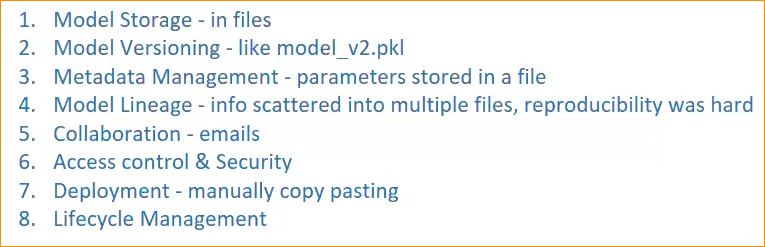

**Stages of Model Lifecycle**

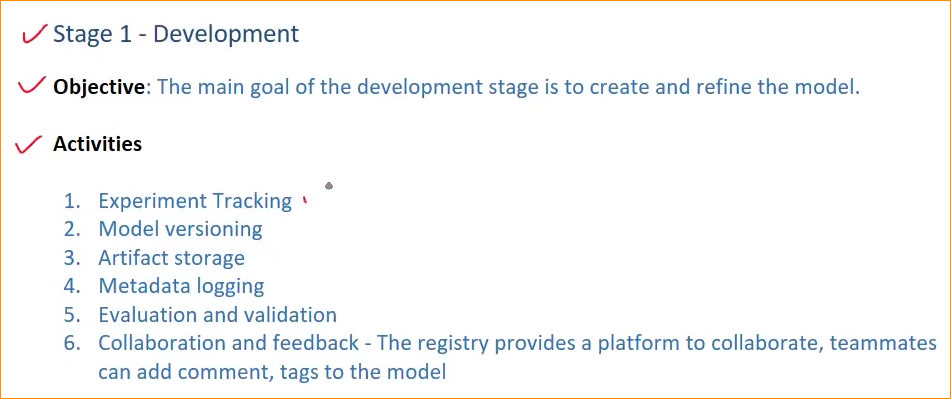

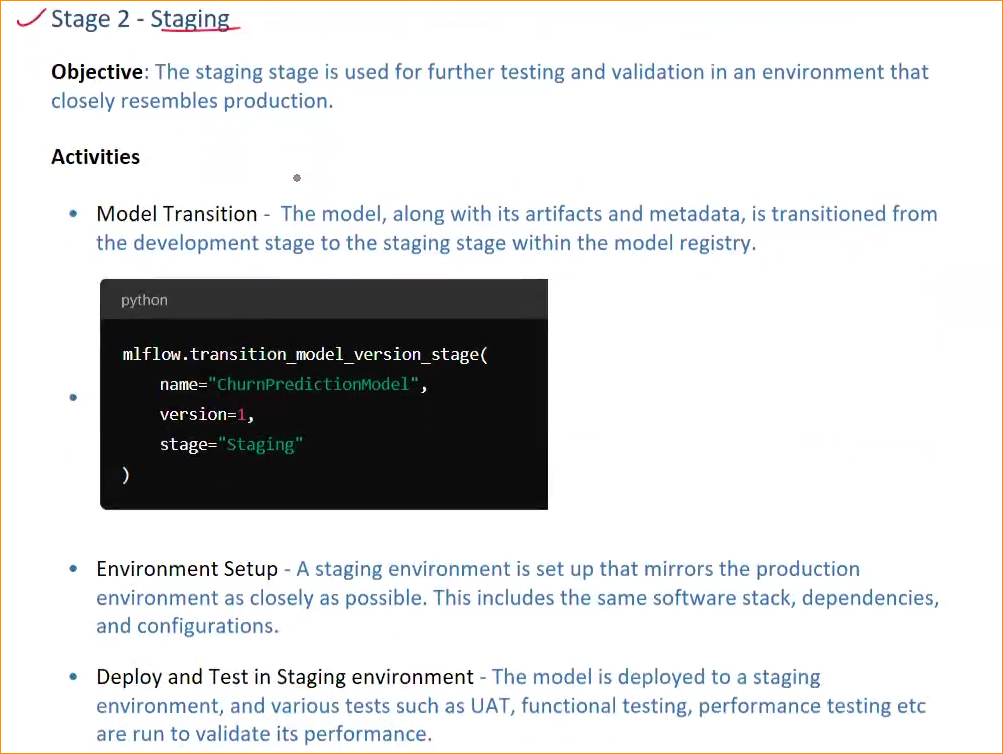

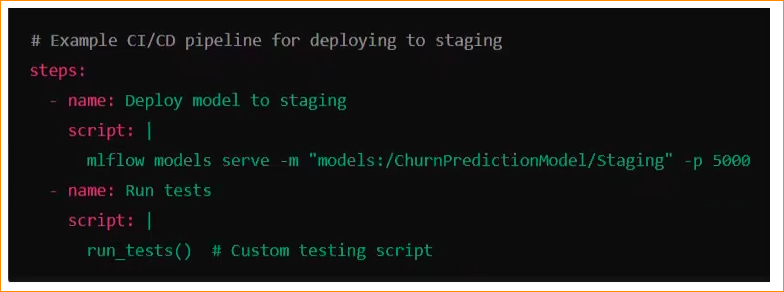

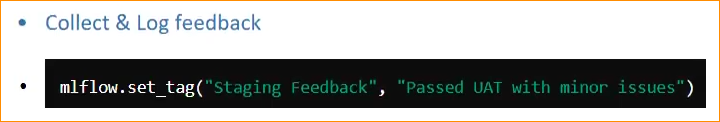

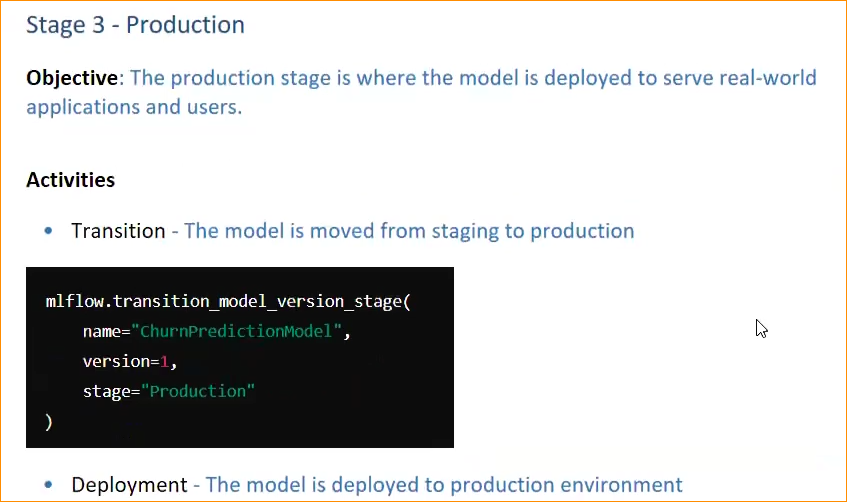

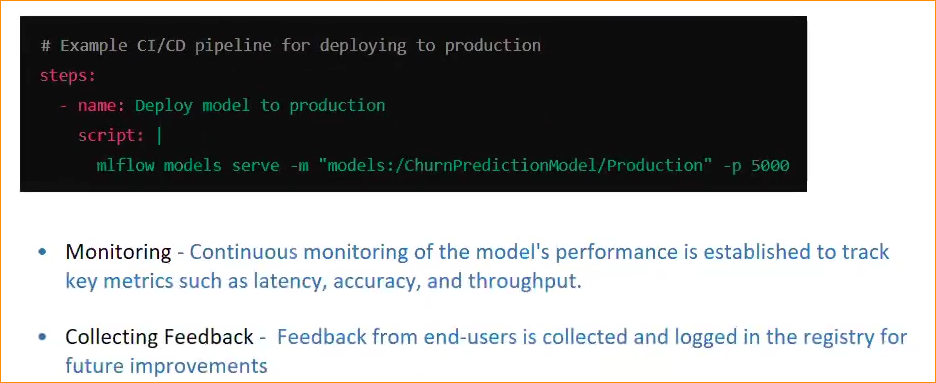

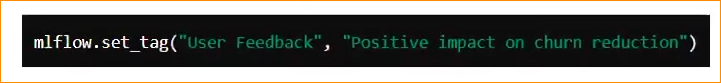

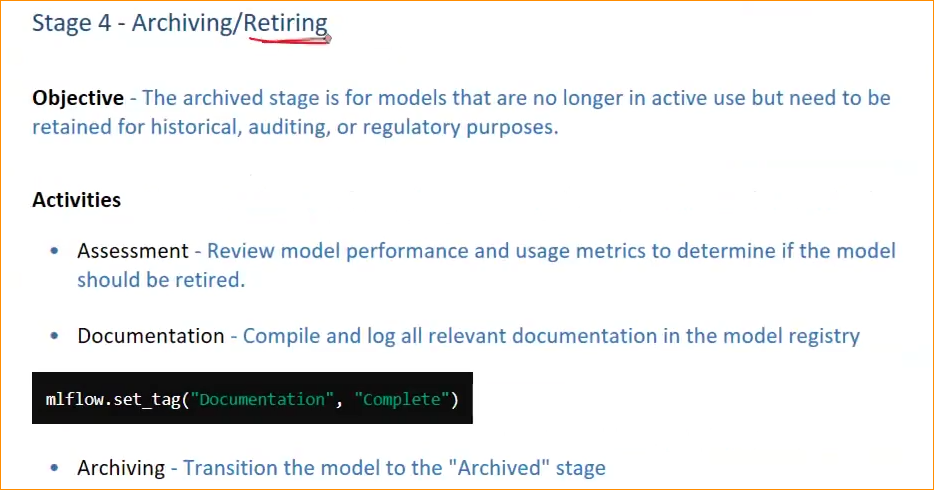

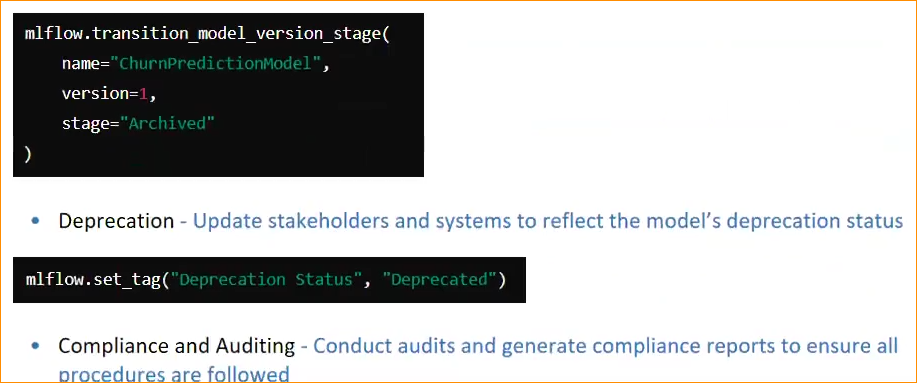

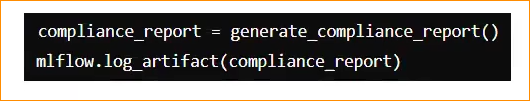

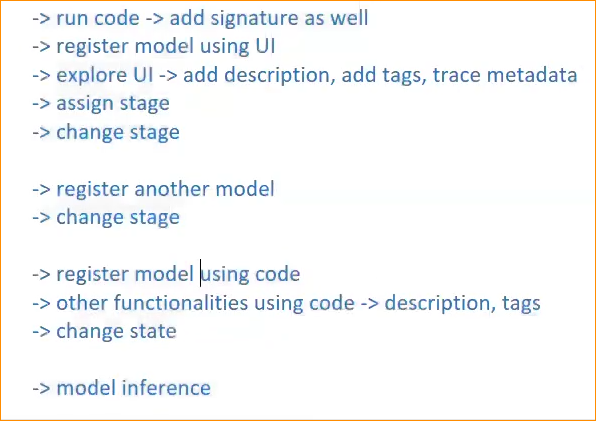

- We have a ran a experiment using hyper parameter and got the best model
- Model is currently logged but We need to register the best model on mlflow

    1. **`register model using UI`**
        - click on register model on UI
        - since its 1st version so create new
        - It will automatically be tagged as v1

        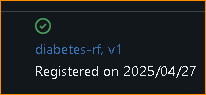

        - navigate to `models` tab
        - Here it will show all the models developed by the team and all information
        - click on model and it will navigate to next page which will have more details
        - we can add model description
        - stage will be showing as `None` since its in development stage
        - `source run` shows the lineage of the model, when we will click on that it will take us to the artifact window of the model which will have code, input data and all the artifacts used at the time of building that model
        - also who created the model, accuracy etc
        
        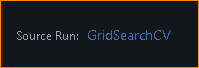

        - We need to move this model to `staging`
        - click on stage on UI and click `transition to staging`
        - It will reflect as staging to everyone and from there testing team will perform all tests and share the feedback that its ok for production

        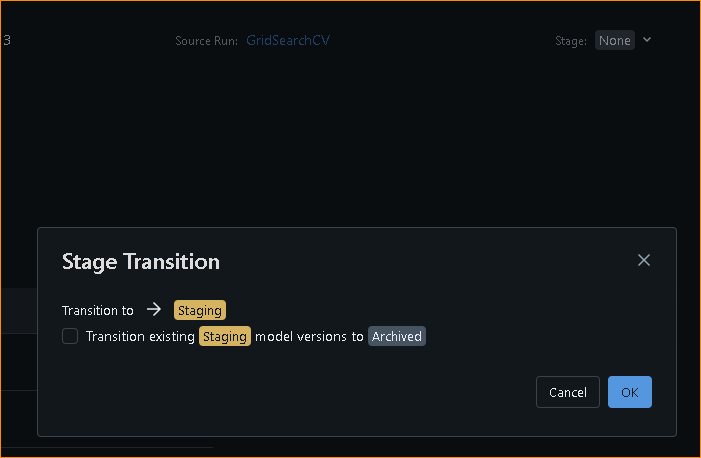

        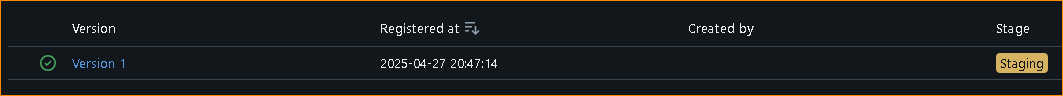

        - click on stage on UI and click `transition to production`
        - Now deoployment team will deploy this model
        
        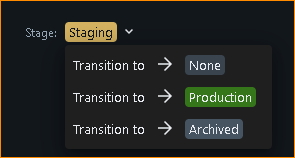

        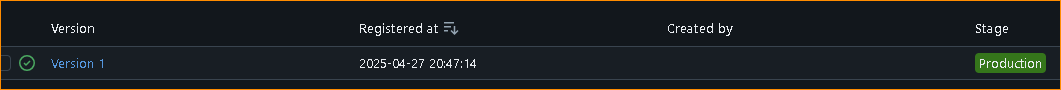

        - After some time of running this model in production, monitoring team notices drift in model and decided to retrain and archive this model
        - so DS team will perform multiple experiments again
        - now we have 2 runs:

        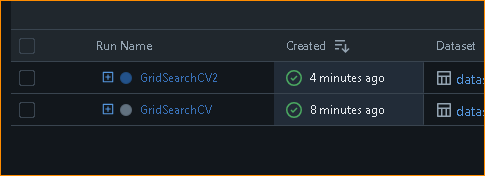

        - We will register the new model
        - Now we will select previous model since its a version upgrade from previous model'

        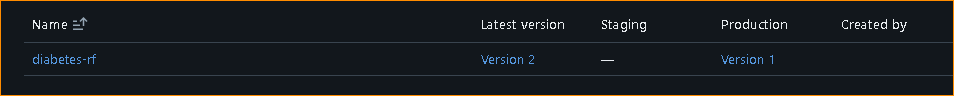

        - We will add description to v2 of model and move model to staging
        - testing team will perform tests and make it ok to prodcution
        - Now at the time of movign model from staging to production, we will archive previous model and move v2 model to production

        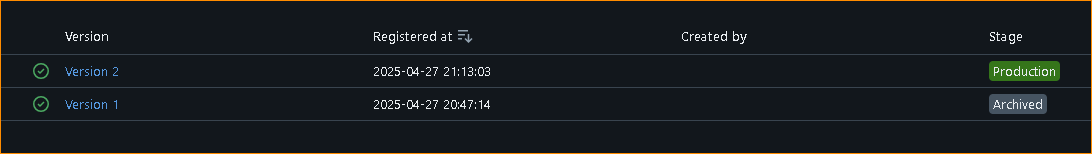

        - Same thing will happen again when v2 will start performing bad, we will archive v2 and move v3 to production and so on
        - everything is visible to everyonce since mlflow is running on cloud, everybody can see which model is in which stage right now
        - both models can be running at the same time, may be on some website we are serving new model and on some website we are serving old models

    2. **`register model using code`**
    - All above can be done using code
    
    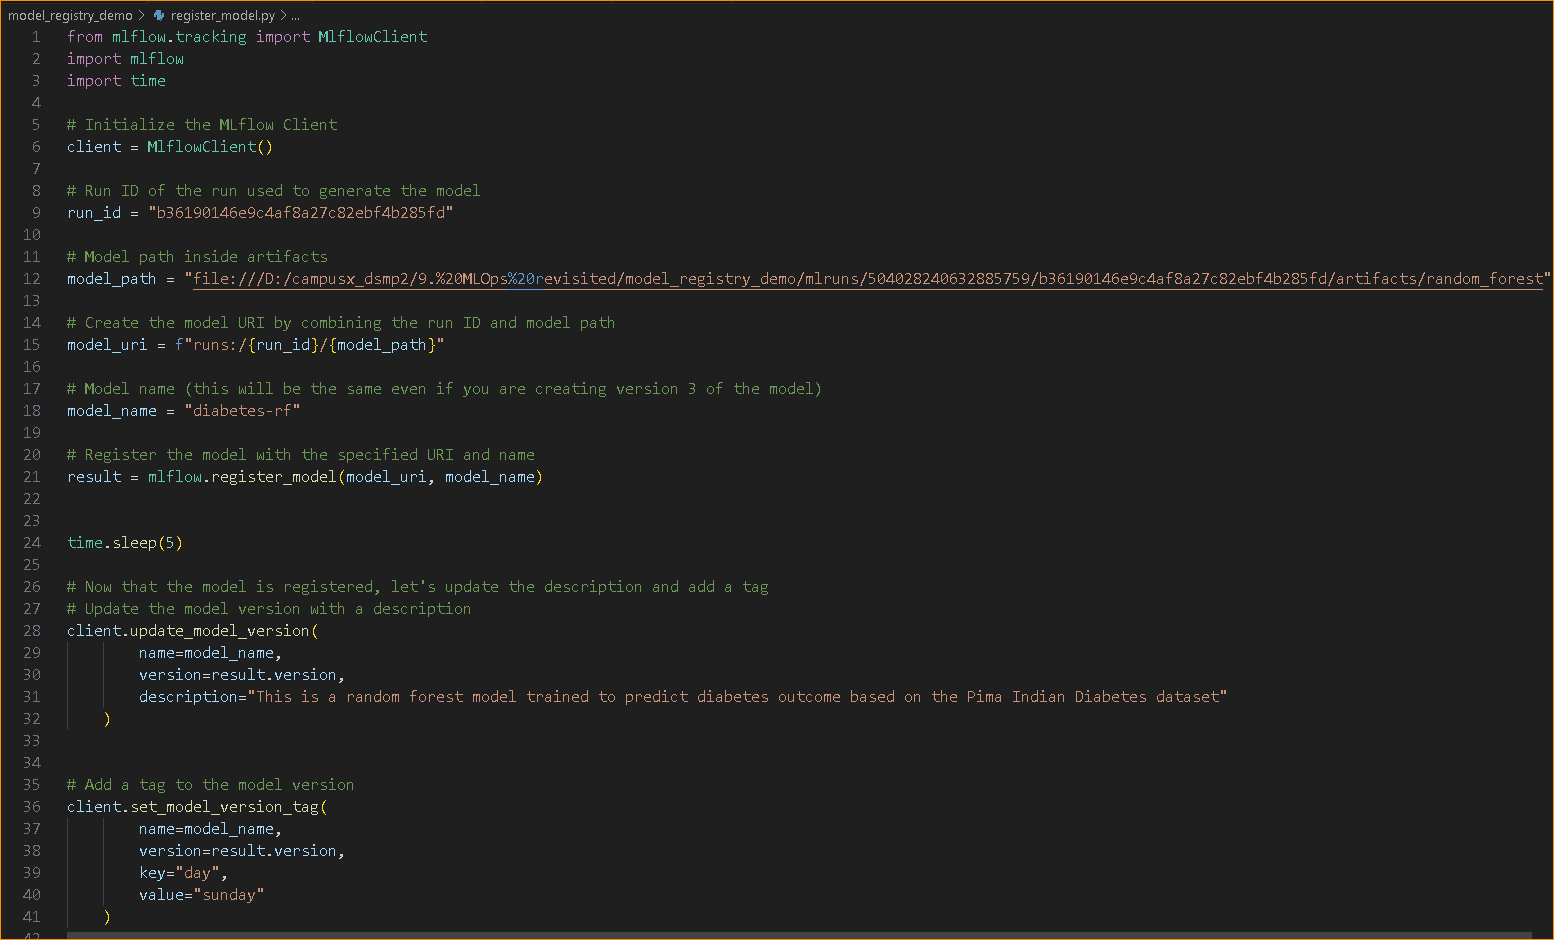

    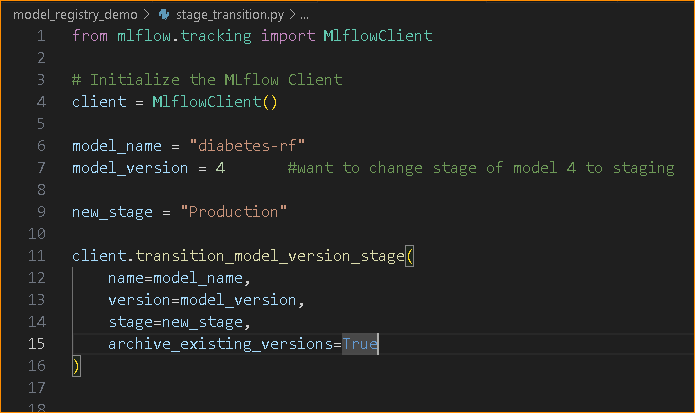

    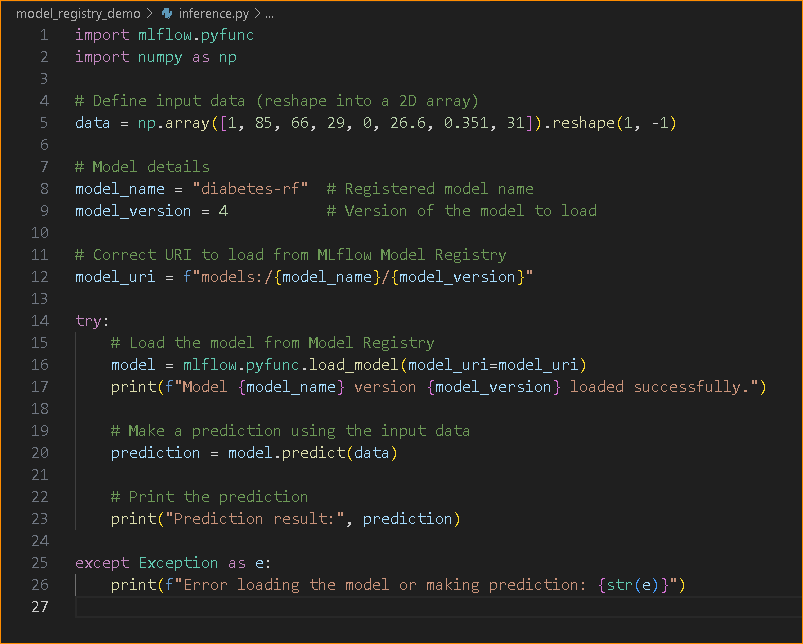

    - We can use the code of inference and make a flas/fast api and move to production


#### Summary

1. **Project Initialization**: Start with a GitHub template or Cookiecutter to create the project structure.
2. **Experimentation**: Conduct all experiments in Jupyter notebooks located in the `notebooks` folder.
3. **Data Storage**: Store datasets in the `Data` folder.
4. **Code Versioning**: Use GitHub for version control of all code.
5. **Data Versioning**: Implement data versioning with S3 for efficient management of dataset versions.
6. **Experiment Tracking**: Track experiments using MLflow on a remote tracking server (e.g., Dagshub or AWS).
7. **Model Selection**: The goal is to identify the best-performing model through systematic experimentation.
8. **Experiment Comparison**: Compare all experiments to select the best model and corresponding parameters.
9. **Pipeline Creation**: Build a reproducible machine learning pipeline using DVC or Airflow.
10. **Code Organization**: Organize all components under the `SRC` folder, and use `dvc.yaml` to link them together.
11. **Version Control for Code**: Store all project code in a GitHub repository.
12. **Model Registration**: Upon running the DVC pipeline, register the best model in the MLflow model registry.

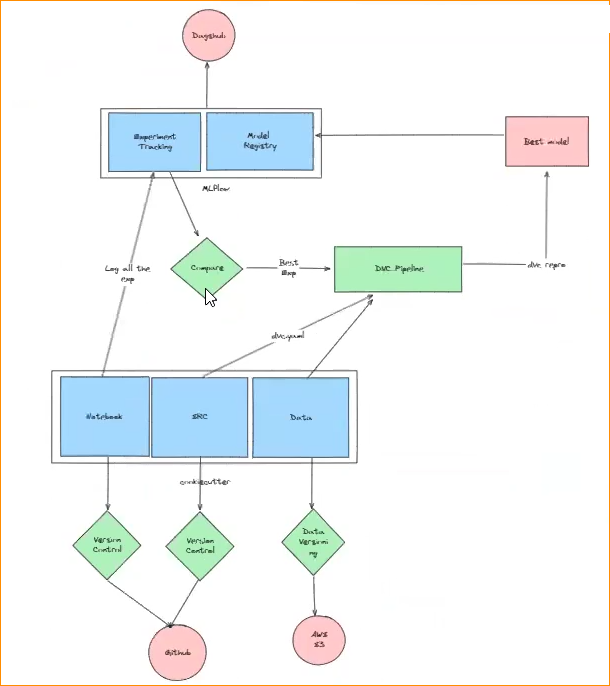

In [3]:
## create 2 projects using all above mlops techniques

### 1. MLOps Mini Project -- Emotion Detection

**Project Setup**
1. create project template using cookiecutter
2. delete useless files
3. create venv
4. git init
5. create git repo
6. add folder to git repo
    `git remote add origin https://github.com/iamprashantjain/mlops-mini-project.git`
7. push code to repo
8. setup mlflow on dasghub & copy mlflow url and code
9. create a test dagshub file to test setup whether it reflects on dagshub mlflow ui

**Experiments**

10. Understand the project and run multiple experiments
11. We have a data to detect sentiments
12. Perform basic preprocessing
13. **Run experiment 1** with simply using BOW + Decision Tree -- find baseline accuracy
14. **Run experiment 2** with using each text vectorization technique for all algorithms -- find best combination
15. **Run experiment 3** perform hyper parameter tuning using best combination -- find best parameters
16. Create DVC pipeline using that combination and create best model
17. Send best model to model registry

#### Experiments

- exp1 baseline model: 0.71 accuracy
- exp2 all combination of both vectorizer & algorithms --- we can compare all of them to get some insights, what parameter effects accuracy in what way

1. like how C parameter effects accuracy, if value of c is high then accuracy is also high

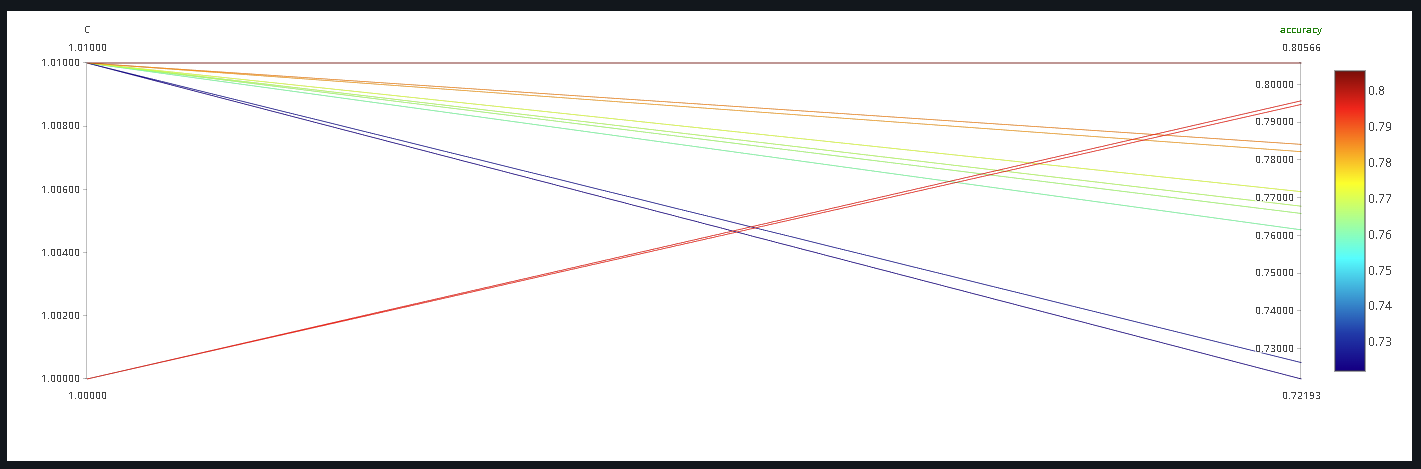

2. n_estimator shows negative corelation

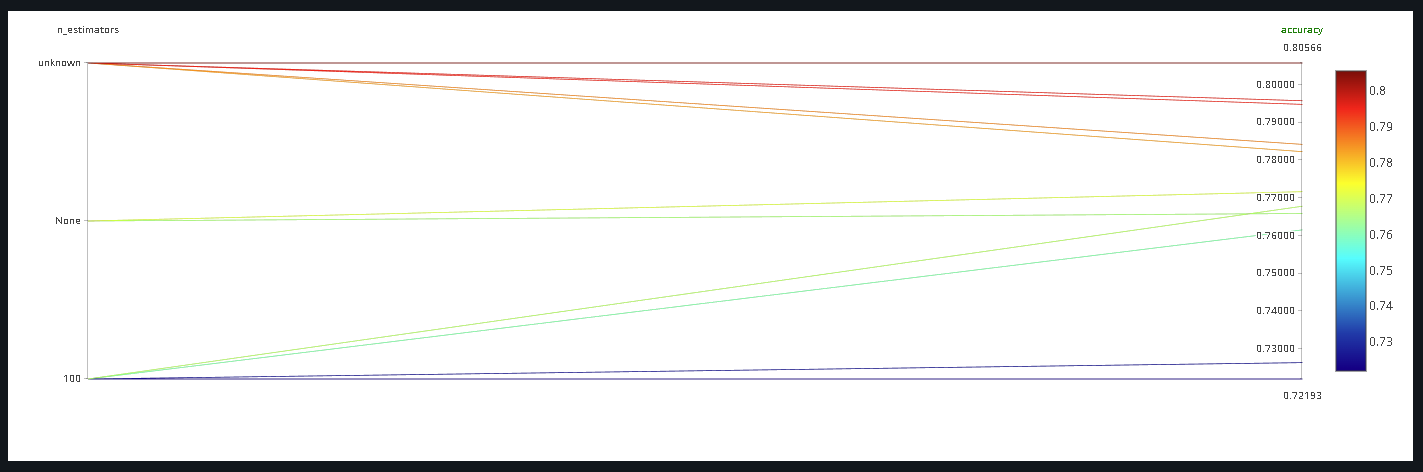

3. Logistic regression is performing best 

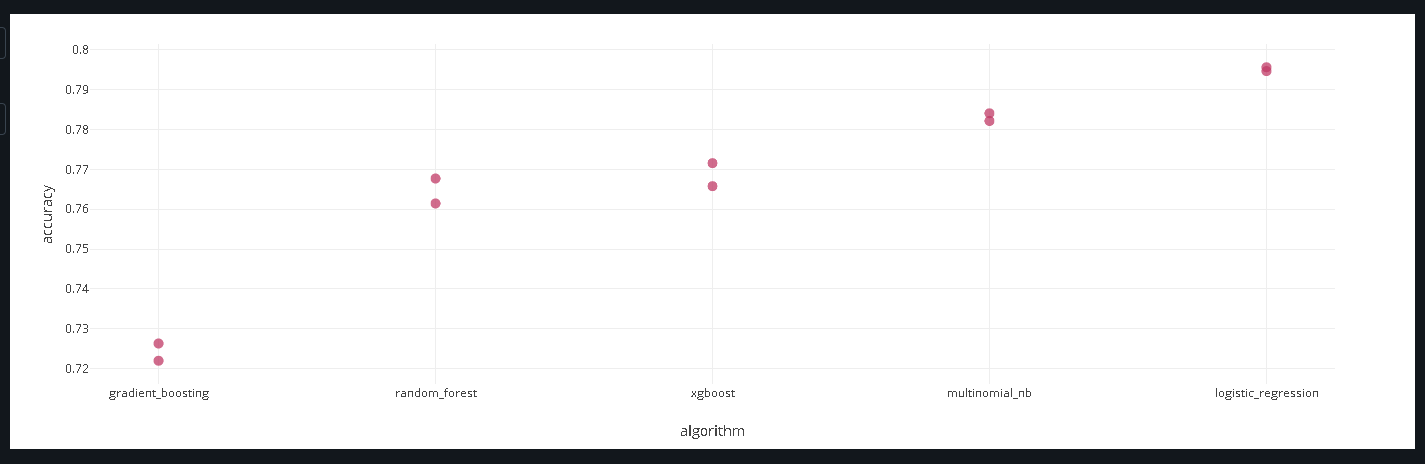

4. both Vectorizer are giving similar results

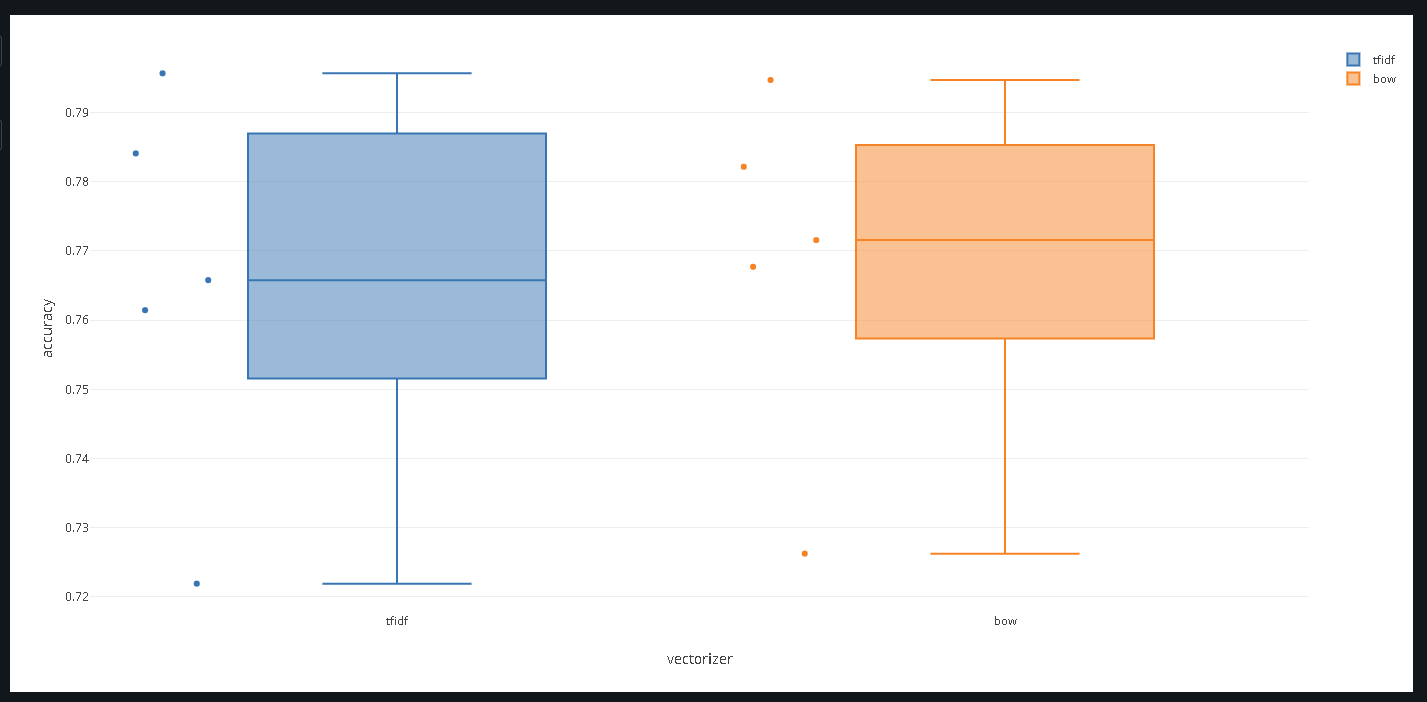


#### **Best combination is Logistic Regression & BOW**

- exp 3 - we will perform hyper parameter tuning on Logistic Regression
- Best Params: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'} Best F1 Score: 0.7904116981776645
- we will convert this to dvc pipeline


#### DVC Pipeline of above code

- dvc init
- dvc remote add (local or s3) `dvc remote add -d myremote C:\Users\iampr\AppData\Local\Temp`
- write all components code: data_ingestion >> data_transformation >> feature_engineering >> model_trainer >> model_evaluation
- create dvc.yaml file (pipeline) & params.yaml file
- run `dvc repro` to run the pipeline
- Also register the model on mlflow and changed from None to Staging
- Now, testing team will test the model and move to production
- From production, Deployment team will take the model and deploy it to production

### 2. MLOps Project -- Car Price Predicition

In [3]:
# session19 completed